# LLM Post-Training Internship Exercise

Welcome to the Hugging Face internship exercise! In our recent blog post on [_Scaling Test-Time Compute with Open Models_](https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute), we explored how search methods and reward models can be used to enhance the performance of LLMs on math problems.

In this exercise, you will be replicating a baseline method from this approach: **Best-of-N sampling with _weighted_ selection**. This approach involves sampling $N$ independent solutions per problem, scoring the solutions with a reward model, and then grouping solutions with the same final answer. The rewards are then summed per group and the final answer with the highest weighted score is chosen as the Best-of-N solution. For more details, refer to the [DeepMind](http://hf.co/papers) and [Math-Shepherd](https://huggingface.co/papers/2312.08935) papers.

We will use the following models from the Hugging Face Hub:
- [**Qwen/Qwen2.5-1.5B-Instruct**](https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct): A 1.5 billion parameter chat model with decent math capabilities for its size.
- [**Skywork/Skywork-o1-Open-PRM-Qwen-2.5-1.5B**](https://huggingface.co/Skywork/Skywork-o1-Open-PRM-Qwen-2.5-1.5B): a 1.5 billion parameter process reward model (PRM). Unlike conventional reward models, PRMs are trained to provide a _sequence_ of scores, one for each step in the LLM's reasoning process.

💡 These models are small enough to run on Google Colab using a free T4 GPU, so make sure you have activated this runtime before progressing!

Concretely, we would like you to work through the following steps:
1. Create a filtered subset of 20 level 1-3 problems from the [MATH-500 dataset](https://huggingface.co/datasets/HuggingFaceH4/MATH-500) (smol models cannot really solve the harder levels). Using these problems:
  - Generate $N=1$ solutions for each problem using greedy decoding; this will be used as a baseline. We recommend prompting the model with chain-of-thought and instructing it to ensure the final answers are contained in `\boxed{answer}` (this helps with parsing).
  - Compute the accuracy of your solutions compared to the ground truth.
3. Sample $N=16$ solutions per problem and score them using the Skywork reward model. Although this model is a PRM, we will use the **_last step prediction_** as our final reward for the full solution. Refer to Appendix E of the [DeepMind](http://hf.co/papers) paper for guidance on using the last step prediction; this involves selecting the final score in the PRM's output sequence.
4. Using the solutions and rewards from Step 2, compute the Best-of-N accuracy with _**weighted**_ selection.
5. Create a dataset of the problems with the greedy and Best-of-N model solutions and push it to the Hugging Face Hub. Then, create a basic [dataset card](https://huggingface.co/docs/hub/datasets-cards) that describes how the dataset was constructed.
6. Create some plots and analysis of the performance of this approach compared to the greedy baseline. For example, which problems was Best-of-N able to solve that greedy decoding couldn't? If time permits, explore how other parameters impact the performance. For example, how accuracy varies with $N$ or temperature.

**Try to spend ~3 hours on the exercise.**

## Tips

* Some steps in the exercise can take ~15 minutes to run on Colab. We recommend familiarising yourself with the remaining steps while waiting for the code to run.
* You can use this [simple helper function](https://gist.github.com/lewtun/9c2ce1937b741404090a3dc4c7c022b3) to extract the answers from the `\boxed{answer}` substrings. In practice, we would use SymPy equivalence but that adds extra complexity.
* The Skywork reward model uses custom modelling code and must be loaded with `trust_remote_code=True`. The authors provide a [repo](https://github.com/SkyworkAI/skywork-o1-prm-inference) with some inference code, but it is possible to use the model directly in `transformers` with `AutoModel.from_pretrained(...)`. You may want to refer to the repo for the PRM scoring helper functions. You will also need to normalize the output logits with a sigmoid function!
* You are welcome to use LLMs (GPT-4o, Claude 3.5, DeepSeek V3, etc) to help you solve this exercise! The only thing we ask is that you indicate which parts of the code were co-authored by an LLM, and that you could explain how the code works if asked :)

## Assessment rubric

What we want to see is whether:

- You have hands-on knowledge of Python and a basic familiarity with the Hugging Face ecosystem.
- You have a good understanding of prompting LLMs and how to generate responses from them.
- You know how to use reward models to improve the quality of language model responses.
- Your code and written explanations can be understood by others. In particular, we like to see simple, readable code over complex over-engineered solutions.


We're especially interested in understanding how you approach projects, so it is important that you can explain the steps you take throughout the notebook. We want to understand what you have tried, so you will be evaluated on your comments just as much as the code itself.

If you feel that you are spending much longer on this exercise than the allotted time, please stop and simply jot down ideas for next steps if you had more time.

Good luck 🤗!

## Summary

### Approach Description

I use two models:
* **Greedy decoding**: Chooses the token with the highest probability at each step without sampling.
* **Weighted Best-of-N**: Samples the next token with a temperature of 0.8.

Both approaches share a 1-shot prompt with an example sampled randomly from a training set. The reported results are from a test set of 20 problems.

### Results

The figure below shows the expected behavior: the weighted Best-of-N outperforms the greedy approach as we increase the number of generations. I also include the vanilla Best-of-N approach, which outperforms the greedy approach but performs worse than the weighted Best-of-N.

![model_comparison](model_comparison.png)

### Error Discussion

The problems that the Best-of-N got right and the greedy approach got wrong are problems in which the greedy approach follows the right process but makes a mistake in a single step. The multiple generations used in the Best-of-N approach help mitigate these specific errors because they give multiple opportunities to repeat the process without mistakes in the steps that the greedy approach misses.

For example, the greedy approach has the correct process except for calculating the perimeter of the rectangle instead of the sum of two sides in problem `test/prealgebra/1252.json`. Some of the generations in the Best-of-N approach get that specific step right, and that's why it gets to the correct answer after the response aggregation.

In my experiments, the Best-of-N method answered correctly all the problems the greedy approach answered correctly. That's why I don't have instances to analyze the greedy approach's advantage over the Best-of-N approach with 16 generations. However, the plot above shows that, given 2 generations, the two approaches achieve the same accuracy. The first point where the greedy method outperforms the Best-of-1 approach is related to the temperature setting, as discussed in the [Hugging Face blog post](https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute).

### Additional Comments
* Comparing the model's answers with the true answers is tricky because they may express the same answer differently. The problem is mitigated by using sympy to get the simplified expressions, but I still have errors. For example, I get that both approaches get the `test/precalculus/441.json` problem wrong. However, both models got the correct answer, and there was a problem with parsing the true solution.
* I set the maximum response length to 1024 tokens because I noticed that the generation was interrupted by the 512 limit. I also mitigated this interruption by asking the model to give short answers. After including these two fixes, no model had the problem of being interrupted.

## Setup

Run the following cell to install the dependencies needed for this exercise.

In [1]:
%pip -qqq install -U transformers datasets accelerate latex2sympy2 sympy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
from typing import Optional
from string import Template

import matplotlib.pyplot as plt
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from huggingface_hub import HfApi, notebook_login
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from latex2sympy2 import latex2sympy
from sympy import latex, simplify

plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
GEN_BATCH_SIZE = 20 # Batch size for response generation
REWARD_BATCH_SIZE = 1 # Batch size for PRM
RANDOM_SEED = 0

N_EXAMPLES = 1 # Number of examples to include in the prompt for the model
TEMPERATURE = 0.8 # Sampling temperature for the Best-of-N model

In [4]:
#notebook_login()

## 0. Helper Functions

In [5]:
prompt_template = Template("""
The following are math problems you need to solve. For each problem, generate a step-by-step solution following the same format as the following examples.

$solution_examples
---
Regardless of the approach, always conclude with:

"Therefore, the final answer is: $$\\boxed{answer}$$. I hope it is correct."

Where [answer] is just the final number or expression that solves the problem.

Keep your answers short and to the point. Always finish highlighting the answer with the `\\boxed{}` command. 
---

Solve the following math problem efficiently and clearly.

Problem:
$problem
""")

def get_solution_examples(dataset: Dataset, n_samples: int = 4) -> str:
    """Generates the examples using the format from the Lewkowycz et al. paper.

    Args:
        dataset (Dataset): Dataset we use to generate the examples.

    Returns:
        str: N samples formatted to use in the prompt.
    """

    sampled_examples = torch.multinomial(torch.ones(len(dataset)), num_samples=n_samples, replacement=False)
    prompt = ""
    for i in sampled_examples:
        prompt += "Problem:\n" + dataset["problem"][i] + "\n"
        prompt += "Solution:\n" + dataset["solution"][i] + "\n\n"
    return prompt


def build_prompt(sample, train_dataset, template, n_samples: int = 4) -> str:
    """Build the prompt using the input problem, n examples and the prompt template.

    Args:
        sample (dict): Dictionary containing the problem to solve.
        train_dataset (Dataset): Dataset we use to sample the examples we show in the prompt.
        template (Template): Template to use to build the prompt.
        n_samples (int, optional): Number of examples to include in the prompt. Defaults to 4.

    Returns:
        str: Prompt with all the elements.
    """
    solution_examples = get_solution_examples(train_dataset, n_samples)
    prompt = template.substitute(solution_examples=solution_examples, problem=sample["problem"])

    return prompt

def extract_boxed_solution(text: str) -> Optional[str]:
    """
    Extracts the content of the last `\boxed{}` in a given LaTeX-style text.
    Args:
        text (str): The input string containing LaTeX-style content.
    Returns:
        Optional[str]: The extracted content inside the last `\boxed{}` if found
        and properly matched, otherwise `None`.
    Example:
        >>> extract_boxed_solution("The result is \\boxed{42}.")
        '42'
        >>> extract_boxed_solution("Unmatched \\boxed{42")
        None
    """
    try:
        start_index = text.rindex("\\boxed{")
        content_start = start_index + 7
        bracket_count = 1
        current_pos = content_start

        while bracket_count > 0 and current_pos < len(text):
            if text[current_pos] == "{":
                bracket_count += 1
            elif text[current_pos] == "}":
                bracket_count -= 1
            current_pos += 1

        if bracket_count == 0:
            content = text[content_start : current_pos - 1].strip()
            return content
        else:
            print("Error: Unmatched brackets in the text")
            return None

    except ValueError:
        print("No boxed solution found in the text")
        return None
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return None

def get_canonical_form(expression: str) -> str:
    """Get the canonical form of a given mathematical expression. The function is taken
    from the Hugging Face blog https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute

    Args:
        expression (str): The input mathematical expression in LaTeX format.

    Returns:
        str: The canonical form of the expression.
    """
    if (expression is None) or len(expression) == 0:
        return ""
    try:
        parsed_expr = latex2sympy(expression)
        simplified_expr = simplify(parsed_expr)
        return latex(simplified_expr)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

def generate_response(model, tokenizer, messages: list, mode: Literal["greedy", "sampling"]) -> str:
    """Generate a response from the model given a set of messages.

    Args:
        model (PreTrainedModel): Model to use for generation.
        tokenizer (PreTrainedTokenizer): Tokenizer to use for generation.
        messages (list): Messages to use as input for the model.  
        mode (str): Generation mode to use. Can be 'greedy' or 'sampling' and sets
        the generation parameters accordingly.

    Raises:
        ValueError: Raised when an unsupported generation mode is used.

    Returns:
        str: The generated response from the model.
    """
    if mode == "greedy":
        gen_params = {
            "temperature": 0,
            "do_sample": False
        }
    elif mode == "sampling":
        gen_params = {
            "temperature": TEMPERATURE,
            "do_sample": True
        }
    else:
        raise ValueError(f"Generation mode {mode} not supported. Use 'greedy' or 'sampling'.")
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer(text, return_tensors="pt", padding=True, padding_side='left').to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        **gen_params
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    del model_inputs, generated_ids
    return response

## 1. Dataset Preparation

### Filtering

I filtered the data with the following criteria:
* Only include problems of levels 1-3 because, as specified in the exercise description, we are interested in problems that a small model can solve.
* Exclude problems that use Asymptote commands to replicate [Lewkowycz et al. (2021)](https://arxiv.org/pdf/2206.14858). I apply that filter by excluding problems and solutions that contain the word `draw`.
* Exclude problems with a description or a solution with more characters than the 0.9 length quantile. This criterion excludes problems over 250 characters and solutions over 1000 characters. This filter is to avoid examples that are computationally expensive to run. **With more compute or time, we wouldn't need this filter.**

### Splitting

The [DeepMind paper](https://arxiv.org/pdf/2408.03314) uses a 4-shot to guide the model to the correct step-by-step output relevant to the PRM model. For that purpose, I split the filtered dataset randomly into two sets to avoid answering the model in the prompt.
1. The training dataset contains problems that I include in the prompt as examples for the model.
2. The test set contains 20 problems for evaluating the model performance.

### Prompt Building

As mentioned above, the DeepMind paper uses a 4-shot approach to generate the responses. I used a 1-shot prompt because of the time and computational constraints, but this is a hyperparameter I could tune to achieve better performance. The Qwen model can handle 4-shot prompts or higher because of its context length of 128k tokens.

In [6]:
raw_ds = load_dataset("HuggingFaceH4/MATH-500")
solution_length_limit = pd.Series(raw_ds["test"]["solution"]).str.len().quantile(0.9)
problem_length_limit = pd.Series(raw_ds["test"]["problem"]).str.len().quantile(0.9)

ds = raw_ds.filter(
    lambda example: (example["level"] <= 3) & ("draw" not in example["problem"]) & ("draw" not in example["solution"]) & (len(example["problem"]) < problem_length_limit) & (len(example["solution"]) < solution_length_limit) 
)

data_splits = ds["test"].train_test_split(test_size=GEN_BATCH_SIZE, seed=RANDOM_SEED)

In [7]:
test_dataset = []
for sample in data_splits["test"]:
    test_dataset.append(
        {
            "problem_id": sample["unique_id"],
            "problem": sample["problem"],
            "solution": sample["solution"],
            "answer": sample["answer"],
            "subject": sample["subject"],
            "level": sample["level"],
            "prompt": build_prompt(sample, data_splits["train"], prompt_template, n_samples=N_EXAMPLES),
        }
    )

test_dataset = Dataset.from_list(test_dataset)
test_dataset = test_dataset.map(
    lambda x: {"message":
        [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": x["prompt"]}
        ]
    }
)
batched_dataset = test_dataset.batch(batch_size=GEN_BATCH_SIZE, drop_last_batch=False)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Batching examples:   0%|          | 0/20 [00:00<?, ? examples/s]

## 2. Greedy Generation


### Greedy Decoding

In [8]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
responses = []
answers = []
true_answers = []
problem_ids = [] 

for batch in tqdm(batched_dataset):
    messages = batch["message"]
    batch_responses = generate_response(model, tokenizer, messages, mode="sampling")
    responses.extend(batch_responses)
    raw_answers = [extract_boxed_solution(response) for response in batch_responses]
    answers.extend([get_canonical_form(answer) for answer in raw_answers])
    true_answers.extend([get_canonical_form(answer) for answer in batch["answer"]])
    problem_ids.extend(batch["problem_id"])

correct = 0
for answer, label in zip(answers, true_answers):
    if answer == label:
        correct += 1

greedy_accuracy = correct / len(true_answers)
print(f"Greedy Accuracy: {greedy_accuracy}")
torch.cuda.empty_cache()

greedy_results_df = pd.DataFrame(
    {
        "problem_id": problem_ids,
        "response": responses,
        "answer": answers,
        "true_answer": true_answers
    }
)
greedy_results_df.to_csv("greedy_results.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

No boxed solution found in the text
Error processing text: I don't understand this
30^\circ
~~~^
Greedy Accuracy: 0.7


## 2. Test-time Compute

In [10]:
results_dfs = []
for sampling_idx in tqdm(range(16)):
    problems = []
    true_answers = []
    responses = []
    model_answers = []
    iter_rewards = []
    problem_ids = []
    for batch in batched_dataset:
        messages = batch["message"]
        batch_responses = generate_response(model, tokenizer, messages, mode="sampling")
        responses.extend(batch_responses)
        model_answers.extend([extract_boxed_solution(response) for response in batch_responses])
        problems.extend(batch["problem"])
        true_answers.extend(batch["answer"])
        problem_ids.extend(batch["problem_id"])

    results_dfs.append(pd.DataFrame(
            {
                "problem_id": problem_ids,
                "message": messages,
                "response": responses,
                "model_answer": model_answers,
                "problem": problems,
                "true_answer": true_answers,
                "sampling_idx": sampling_idx,
            }
        )
    )
results_df = pd.concat(results_dfs)
del model, batch
torch.cuda.empty_cache()

  0%|          | 0/16 [00:00<?, ?it/s]

No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text
No boxed solution found in the text


In [13]:
!git clone https://github.com/SkyworkAI/skywork-o1-prm-inference.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into 'skywork-o1-prm-inference'...



In [17]:
sys.path.append("skywork-o1-prm-inference")
from model_utils.prm_model import PRM_MODEL
from model_utils.io_utils import prepare_input, prepare_batch_input_for_model, derive_step_rewards

In [18]:
prm_model_path = "Skywork/Skywork-o1-Open-PRM-Qwen-2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(prm_model_path, trust_remote_code=True)
prm_model = PRM_MODEL.from_pretrained(prm_model_path, device_map="auto").eval()

In [20]:
all_rewards = []
problems = results_df["problem"].to_list()
responses = results_df["response"].to_list()
for idx in tqdm(range(0, len(results_df), REWARD_BATCH_SIZE)):
    # Prepare inputs
    processed_data = [
        prepare_input(problem, response, tokenizer=tokenizer, step_token="\n")
        for problem, response in zip(problems[idx: idx + REWARD_BATCH_SIZE], responses[idx: idx + REWARD_BATCH_SIZE])
    ]
    input_ids, steps, reward_flags = zip(*processed_data)
    input_ids, attention_mask, reward_flags = prepare_batch_input_for_model(
        input_ids, reward_flags, tokenizer.pad_token_id
    )

    # Calculate rewards
    _, _, rewards = prm_model(
        input_ids=input_ids.to(prm_model.pretrained_model.device),
        attention_mask=attention_mask.to(prm_model.pretrained_model.device),
        return_probs=True
    )
    step_rewards = derive_step_rewards(rewards, reward_flags)

    # Use the last-step reward
    all_rewards.extend([step_reward[-1] for step_reward in step_rewards])

results_df["reward"] = all_rewards
results_df = results_df.replace({None: ''})

results_df["simplified_model_answer"] = results_df["model_answer"].apply(get_canonical_form)
results_df["simplified_true_answer"] = results_df["true_answer"].apply(get_canonical_form)

results_df.to_csv("reward_results.csv", index=False)

  0%|          | 0/320 [00:00<?, ?it/s]

Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
\frac{\sin^2 18^\circ (\sqrt{5} + 3)}{4}
~~~~~~~~~~~~~~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understand this
30^\circ
~~~^
Error processing text: I don't understan

In [21]:
problem_ids = []
answers = []
true_answers = []
model_responses = []

correct = 0
for problem_id in results_df["problem_id"].unique():
    # Group the same answers and calculate the total reward
    problem_df = results_df[results_df["problem_id"] == problem_id]
    answer_df = problem_df[["simplified_model_answer", "reward"]]
    answer_df = answer_df.groupby("simplified_model_answer").sum()

    # Find the answer with the highest reward
    best_answer = answer_df["reward"].idxmax()
    true_answer = problem_df["simplified_true_answer"].iloc[0]

    # Calculate correctness
    if (best_answer == true_answer) and (best_answer != ""):
        correct += 1

    # Log results
    best_responses = problem_df[problem_df["simplified_model_answer"] ==  best_answer]
    best_response = best_responses.sort_values("reward", ascending=False)["response"].iloc[0]

    problem_ids.append(problem_id)
    answers.append(best_answer)
    model_responses.append(best_response)
    true_answers.append(true_answer)

weighted_accuracy = correct / len(results_df["problem_id"].unique())

weighted_results_df = pd.DataFrame(
    {
        "problem_id": problem_ids,
        "response": model_responses,
        "answer": answers,
        "true_answer": true_answers
    }
)
weighted_results_df.to_csv("weighted_results.csv", index=False)

## Analysis

In [22]:
n_generations = []
weighted_accuracies = []
vanilla_accuracies = []

# Calculate accuracy on different number of samples
for sampling_idx in [1, 2, 4, 8, 16]:
    correct = 0
    vanilla_correct = 0
    for problem_id in results_df["problem_id"].unique():
        problem_df = results_df[(results_df["problem_id"] == problem_id) & (results_df["sampling_idx"] < sampling_idx)]
        answer_df = problem_df[["simplified_model_answer", "reward"]]
        answer_df = answer_df.groupby("simplified_model_answer").sum()
        if len(answer_df) == 0:
            continue
        # Find the answer with the highest reward
        best_answer = answer_df["reward"].idxmax()
        true_answer = problem_df["simplified_true_answer"].iloc[0]
        if (best_answer == true_answer) and (best_answer != ""):
            correct += 1

        vanilla_df = problem_df[["simplified_model_answer", "reward"]]
        vanilla_df = vanilla_df.groupby("simplified_model_answer").max()
        vanilla_best_answer = vanilla_df["reward"].idxmax()
        if len(vanilla_df) == 0:
            continue
        if (vanilla_best_answer == true_answer) and (vanilla_best_answer != ""):
            vanilla_correct += 1

    weighted_accuracy = correct / len(results_df["problem_id"].unique())
    vanilla_accuracy = vanilla_correct / len(results_df["problem_id"].unique())
    weighted_accuracies.append(weighted_accuracy)
    vanilla_accuracies.append(vanilla_accuracy)
    n_generations.append(sampling_idx)

### Plot Comparison

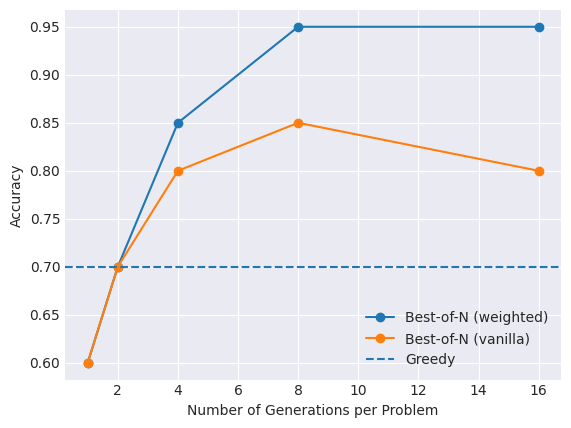

In [23]:
fig, ax = plt.subplots()
ax.plot(n_generations, weighted_accuracies, marker="o", label="Best-of-N (weighted)")
ax.plot(n_generations, vanilla_accuracies, marker="o", label="Best-of-N (vanilla)")
ax.axhline(greedy_accuracy, linestyle="--", label="Greedy")

ax.set_xlabel("Number of Generations per Problem")
ax.set_ylabel("Accuracy")
ax.legend()
fig.savefig("model_comparison.png")

In [24]:
output_df = greedy_results_df.merge(weighted_results_df, on="problem_id", suffixes=('_greedy', '_weighted'))

test_dataset_df = test_dataset.to_pandas()
test_dataset_df = test_dataset_df[["problem_id", "problem", "solution", "answer", "subject", "level"]]
output_df = test_dataset_df.merge(output_df, on="problem_id")
output_df.to_parquet("math500_subset.parquet", index=False)

api = HfApi()
api.upload_file(
    path_or_fileobj="math500_subset.parquet",
    path_in_repo="math500_subset.parquet",
    repo_id="cmpatino/math500_post-training",
    repo_type="dataset",
)

math500_subset.parquet:   0%|          | 0.00/45.8k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cmpatino/math500_post-training/commit/8c488216fd21a0a76572686023cc20456771ecee', commit_message='Upload math500_subset.parquet with huggingface_hub', commit_description='', oid='8c488216fd21a0a76572686023cc20456771ecee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/cmpatino/math500_post-training', endpoint='https://huggingface.co', repo_type='dataset', repo_id='cmpatino/math500_post-training'), pr_revision=None, pr_num=None)

### Approach Strengths

In [25]:
output_df["correct_greedy"] = output_df["answer_greedy"] == output_df["true_answer_greedy"]
output_df["correct_weighted"] = output_df["answer_weighted"] == output_df["true_answer_weighted"]

#### Both Models Get Wrong

In [33]:
weakness_df = output_df[~output_df["correct_weighted"] & ~output_df["correct_greedy"]]
weakness_df

,problem_id,problem,solution,answer,subject,level,response_greedy,answer_greedy,true_answer_greedy,response_weighted,answer_weighted,true_answer_weighted,correct_greedy,correct_weighted
4,test/precalculus/441.json,If $\mathbf{a}$ and $\mathbf{b}$ are vectors s...,Let $\theta$ be the angle between $\mathbf{a}$...,30^\circ,Precalculus,2,To find the smallest possible angle between th...,30,,To find the smallest possible angle between th...,30,,False,False


In [35]:
print(weakness_df.iloc[0]["response_weighted"])

To find the smallest possible angle between the vectors \(\mathbf{a}\) and \(\mathbf{b}\), we start by using the formula for the magnitude of the cross product of two vectors. The magnitude of the cross product \(\mathbf{a} \times \mathbf{b}\) is given by:

\[
\|\mathbf{a} \times \mathbf{b}\| = \|\mathbf{a}\| \|\mathbf{b}\| \sin \theta
\]

where \(\theta\) is the angle between the vectors \(\mathbf{a}\) and \(\mathbf{b}\). Given that \(\|\mathbf{a}\| = 2\), \(\|\mathbf{b}\| = 7\), and \(\mathbf{a} \times \mathbf{b} = \begin{pmatrix} 3 \\ 2 \\ 6 \end{pmatrix}\), we can substitute these values into the equation:

\[
\|\mathbf{a} \times \mathbf{b}\| = \|\mathbf{a}\| \|\mathbf{b}\| \sin \theta = 2 \cdot 7 \cdot \sin \theta = 14 \sin \theta
\]

The magnitude of the vector \(\begin{pmatrix} 3 \\ 2 \\ 6 \end{pmatrix}\) is calculated as follows:

\[
\|\begin{pmatrix} 3 \\ 2 \\ 6 \end{pmatrix}\| = \sqrt{3^2 + 2^2 + 6^2} = \sqrt{9 + 4 + 36} = \sqrt{49} = 7
\]

So, we have:

\[
14 \sin \theta = 7

In [38]:
print(weakness_df.iloc[0]["response_greedy"])

To find the smallest possible angle between the vectors \(\mathbf{a}\) and \(\mathbf{b}\), we start by using the definition of the cross product. The magnitude of the cross product \(\mathbf{a} \times \mathbf{b}\) can be expressed in terms of the magnitudes of \(\mathbf{a}\) and \(\mathbf{b}\) and the sine of the angle \(\theta\) between them. Specifically,

\[
\|\mathbf{a} \times \mathbf{b}\| = \|\mathbf{a}\| \|\mathbf{b}\| \sin \theta.
\]

Given \(\|\mathbf{a}\| = 2\), \(\|\mathbf{b}\| = 7\), and \(\mathbf{a} \times \mathbf{b} = \begin{pmatrix} 3 \\ 2 \\ 6 \end{pmatrix}\), we first calculate the magnitude of \(\mathbf{a} \times \mathbf{b}\):

\[
\|\mathbf{a} \times \mathbf{b}\| = \sqrt{3^2 + 2^2 + 6^2} = \sqrt{9 + 4 + 36} = \sqrt{49} = 7.
\]

Substituting the known values into the equation for the magnitude of the cross product, we get:

\[
7 = 2 \cdot 7 \cdot \sin \theta.
\]

Solving for \(\sin \theta\), we have:

\[
\sin \theta = \frac{7}{2 \cdot 7} = \frac{1}{2}.
\]

The angle who

In [26]:
greedy_strengths_df = output_df[output_df["correct_greedy"] & ~output_df["correct_weighted"]]
greedy_strengths_df

,problem_id,problem,solution,answer,subject,level,response_greedy,answer_greedy,true_answer_greedy,response_weighted,answer_weighted,true_answer_weighted,correct_greedy,correct_weighted


In [27]:
weighted_strengths_df = output_df[(~output_df["correct_greedy"]) & (output_df["correct_weighted"])]
weighted_strengths_df

,problem_id,problem,solution,answer,subject,level,response_greedy,answer_greedy,true_answer_greedy,response_weighted,answer_weighted,true_answer_weighted,correct_greedy,correct_weighted
0,test/algebra/2680.json,Simplify $\frac{(10r^3)(4r^6)}{8r^4}$.,We have \[\frac{(10r^3)(4r^6)}{8r^4}= \frac{4...,5r^5,Algebra,2,To simplify the given expression \(\frac{(10r^...,,5 r^{5},To simplify the given expression \(\frac{(10r^...,5 r^{5},5 r^{5},False,True
1,test/intermediate_algebra/991.json,If $m$ and $n$ are integers such that $3m + 4n...,From $3m + 4n = 100$ we can get that $n = 25 -...,3,Intermediate Algebra,2,To find the smallest possible value of \( |m -...,25,3,To find the smallest possible value of \( |m -...,3,3,False,True
11,test/precalculus/681.json,Compute $\sin^3 18^\circ + \sin^2 18^\circ.$,We can write\n\begin{align*}\n\sin^3 18^\circ ...,\frac{1}{8},Precalculus,3,To compute \(\sin^3 18^\circ + \sin^2 18^\circ...,\frac{3 \sqrt{3}}{8} + \frac{3}{4},\frac{1}{8},To compute \(\sin^3 18^\circ + \sin^2 18^\circ...,\frac{1}{8},\frac{1}{8},False,True
15,test/prealgebra/1252.json,Jim and Martha are standing together at the co...,The diagonal of the field is $\sqrt{300^2+400^...,200,Prealgebra,2,To determine how much less distance Jim walks ...,900,200,To determine how many feet less than Martha Ji...,200,200,False,True
17,test/number_theory/183.json,What is the sum of the digits in the terminati...,Rewriting $\frac{4321}{5^7\cdot2^8}$ as a deci...,14,Number Theory,3,To find the sum of the digits in the terminati...,17,14,To find the sum of the digits in the terminati...,14,14,False,True


In [36]:
for _, row in weighted_strengths_df.iterrows():
    print(f"====================================================")
    print("Weighted Response:")
    print(row["response_weighted"])
    print("********")
    print("Greedy Response:")
    print(row["response_greedy"])
    print()

Weighted Response:
To simplify the given expression \(\frac{(10r^3)(4r^6)}{8r^4}\), we will follow these steps:

1. **Multiply the coefficients**: The coefficients in the numerator are \(10\) and \(4\). Multiply them together.
   \[
   10 \times 4 = 40
   \]

2. **Multiply the variables**: The variables in the numerator are \(r^3\) and \(r^6\). Use the property of exponents \(a^m \cdot a^n = a^{m+n}\) to add the exponents.
   \[
   r^3 \cdot r^6 = r^{3+6} = r^9
   \]
   
3. **Combine the results**: Now combine the multiplied coefficient and the variable parts.
   \[
   \frac{40r^9}{8r^4}
   \]

4. **Divide the coefficients**: Divide the coefficient \(40\) by \(8\).
   \[
   \frac{40}{8} = 5
   \]

5. **Subtract the exponents for the variables**: Subtract the exponent of the denominator \(r^4\) from the exponent of the numerator \(r^9\).
   \[
   r^9 \div r^4 = r^{9-4} = r^5
   \]

6. **Combine the simplified components**: Combine the simplified coefficient and the variable part.
   \[
